Prepare solution to build ticketing system there by using json file as your primary datasource (Text corpus with other metadata in it). 
1.  Group data into five categories namely Banking services, loans, Fraudalent reporting, Card, others.
2. From step 1 create labeled dataset and utilize it to train supervised model like logistic regression, decision tree or random forest.


Above excercise should follow these steps -
1. Load Data
2. Text Preprocessing
3. EDA
4. Feature Extraction
5. Topic Modelling (Unsupervised)
6. Model building using Supervised learning
7. Model Training and evaluation
8. Inference

# Import Libraries

In [136]:
import numpy as np
import pandas as pd
import re, nltk, spacy, string

In [137]:
import json

# Loading Data

In [138]:
f = open('Client_data.json')

In [139]:
data = json.load(f)

In [140]:
dataset = pd.json_normalize(data)
dataset.head(5)

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [141]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [142]:
dataset['_source.complaint_what_happened'] = dataset['_source.complaint_what_happened'].astype(str)

In [143]:
dataset['_source.product'] = dataset['_source.product'].astype(str)

In [144]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [145]:
df = dataset[['_source.complaint_what_happened', '_source.product']]
df.head()

,_source.complaint_what_happened,_source.product
0,,Debt collection
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card
3,,Mortgage
4,,Credit card or prepaid card


In [146]:
df.isnull().sum()

_source.complaint_what_happened    0
_source.product                    0
dtype: int64

In [147]:
df.shape

(78313, 2)

# Text Preprocessing

In [148]:
df.rename(columns = {'_source.complaint_what_happened':'Complaint', '_source.product':'Product',
                              }, inplace = True)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [149]:
df.head()

,Complaint,Product
0,,Debt collection
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card
3,,Mortgage
4,,Credit card or prepaid card


In [150]:
df[df.loc[:, 'Complaint'] == ''] = np.nan

<ipython-input-150-989971b52fab>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df.loc[:, 'Complaint'] == ''] = np.nan
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

In [152]:
df = df[~df['Complaint'].isnull()]

In [153]:
df.shape

(21072, 2)

In [154]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21072 entries, 1 to 78312
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Complaint  21072 non-null  object
 1   Product    21072 non-null  object
dtypes: object(2)
memory usage: 493.9+ KB


In [155]:
#df['Product'].unique()

In [156]:
# Lowercasing Complaints
df['Complaint'] = df['Complaint'].str.lower()
df.head()

<ipython-input-156-3604be78d04e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Complaint'] = df['Complaint'].str.lower()


,Complaint,Product
1,good morning my name is xxxx xxxx and i apprec...,Debt collection
2,i upgraded my xxxx xxxx card in xx/xx/2018 and...,Credit card or prepaid card
10,chase card was reported on xx/xx/2019. however...,"Credit reporting, credit repair services, or o..."
11,"on xx/xx/2018, while trying to book a xxxx xx...","Credit reporting, credit repair services, or o..."
14,my grand son give me check for {$1600.00} i de...,Checking or savings account


In [157]:
# Lowercasing Product
df['Product'] = df['Product'].str.lower()
df.head()

<ipython-input-157-64feef22698e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Product'] = df['Product'].str.lower()


,Complaint,Product
1,good morning my name is xxxx xxxx and i apprec...,debt collection
2,i upgraded my xxxx xxxx card in xx/xx/2018 and...,credit card or prepaid card
10,chase card was reported on xx/xx/2019. however...,"credit reporting, credit repair services, or o..."
11,"on xx/xx/2018, while trying to book a xxxx xx...","credit reporting, credit repair services, or o..."
14,my grand son give me check for {$1600.00} i de...,checking or savings account


In [158]:
# Removing Punctuations
df['Complaint'] = df['Complaint'].str.replace('[^A-Za-z0-9]+',' ', regex=True)
df.head()

,Complaint,Product
1,good morning my name is xxxx xxxx and i apprec...,debt collection
2,i upgraded my xxxx xxxx card in xx xx 2018 and...,credit card or prepaid card
10,chase card was reported on xx xx 2019 however ...,"credit reporting, credit repair services, or o..."
11,on xx xx 2018 while trying to book a xxxx xxxx...,"credit reporting, credit repair services, or o..."
14,my grand son give me check for 1600 00 i depos...,checking or savings account


In [159]:
from nltk.corpus import stopwords

In [160]:
nltk.download('stopwords')
stopwords = stopwords.words('english')
stopwords.append('xxxx')
stopwords.append('xx')
stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [161]:
# Removing Stopwords
df['Complaint'] = df['Complaint'].apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stopwords))
df['Product'] = df['Product'].apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stopwords))
df.head()

,Complaint,Product
1,good morning name appreciate could help put st...,debt collection
2,upgraded card 2018 told agent upgrade annivers...,credit card prepaid card
10,chase card reported 2019 however fraudulent ap...,"credit reporting, credit repair services, pers..."
11,2018 trying book ticket came across offer 300 ...,"credit reporting, credit repair services, pers..."
14,grand son give check 1600 00 deposit chase acc...,checking savings account


In [162]:
df = df.sample(3000)

In [163]:
import en_core_web_sm
nlp = en_core_web_sm.load()
nltk.download('wordnet')
def lemmatize_text(text):
    sent = []
    doc = nlp(text)
    for token in doc:
        sent.append(token.lemma_)
    return " ".join(sent)
df['lemmatized_Complaint'] = df['Complaint'].apply(lemmatize_text)
df['lemmatized_Product'] = df['Product'].apply(lemmatize_text)
df.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Complaint,Product,lemmatized_Complaint,lemmatized_Product
61764,2016 balance chase checking account incoming r...,bank account service,2016 balance chase checking account incoming r...,bank account service
69861,process trying close checking savings account ...,checking savings account,process try close checking saving account dece...,check saving account
61864,bank accounts chase bank checking account savi...,bank account service,bank account chase bank check account saving a...,bank account service
73466,entire loan rip time got used car 2018 dealers...,vehicle loan lease,entire loan rip time got use car 2018 dealersh...,vehicle loan lease
40863,wanted get house payment could better able aff...,mortgage,want get house payment could better able affor...,mortgage


# EDA (Exploratory Data Analysis)

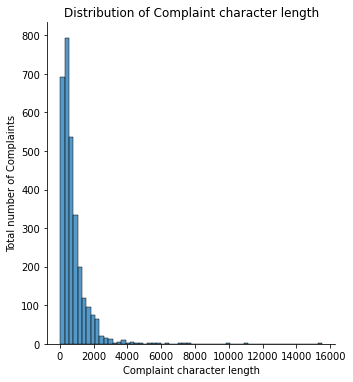

In [164]:
import seaborn as sns
import matplotlib.pyplot as plt
char_len = [len(each_sent) for each_sent in df['lemmatized_Complaint']]

sns.displot(char_len, kind='hist', bins=60)
plt.xlabel("Complaint character length")
plt.ylabel("Total number of Complaints")
plt.title("Distribution of Complaint character length")
plt.show()

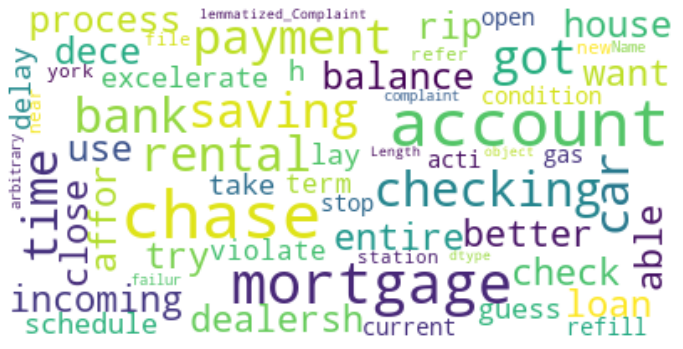

In [165]:
# Wordcloud for complaint
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
wordcloud = WordCloud(max_font_size=40, max_words=80, 
                      background_color="white", random_state=100, 
                      stopwords=stopwords).generate(str(df['lemmatized_Complaint']))
plt.figure(figsize=[12,12])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


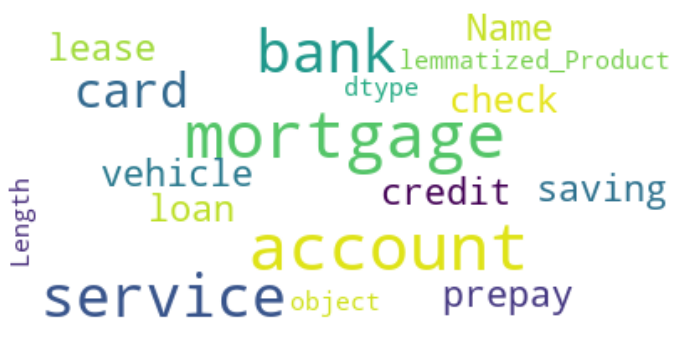

In [166]:
#wordcloud for product
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
wordcloud = WordCloud(max_font_size=40, max_words=80, 
                      background_color="white", random_state=100, 
                      stopwords=stopwords).generate(str(df['lemmatized_Product']))
plt.figure(figsize=[12,12])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Feature Extraction

In [167]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve
from pprint import pprint

In [168]:
tfidf = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')

In [169]:
dtm = tfidf.fit_transform(df['lemmatized_Complaint'])

In [170]:
dtm

<3000x5365 sparse matrix of type '<class 'numpy.float64'>'
	with 170326 stored elements in Compressed Sparse Row format>

# Topic Modelling (Unsupervised)

In [171]:
from sklearn.decomposition import NMF

In [172]:
#Loading nmf_model with 5 components
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [173]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names())

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


5365

In [174]:
H = nmf_model.components_       # Topic-term matrix

In [175]:
#Print the Top15 words for each of the topics
words = np.array(tfidf.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics, 10)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(10)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:10]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10
Topic 1,account,check,bank,chase,money,deposit,fund,close,tell,open
Topic 2,credit,card,report,inquiry,chase,account,apply,remove,hard,score
Topic 3,loan,mortgage,chase,home,modification,property,year,send,letter,document
Topic 4,charge,00,card,dispute,fee,chase,transaction,refund,claim,merchant
Topic 5,payment,late,pay,make,balance,month,00,fee,statement,credit


In [176]:
#Creating the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_results = nmf_model.transform(dtm)

In [177]:
#Assigning the best topic to each of the complaints in Topic Column
df['Topic'] = topic_results.argmax(axis=1)

In [178]:
df.head()

,Complaint,Product,lemmatized_Complaint,lemmatized_Product,Topic
61764,2016 balance chase checking account incoming r...,bank account service,2016 balance chase checking account incoming r...,bank account service,3
69861,process trying close checking savings account ...,checking savings account,process try close checking saving account dece...,check saving account,2
61864,bank accounts chase bank checking account savi...,bank account service,bank account chase bank check account saving a...,bank account service,0
73466,entire loan rip time got used car 2018 dealers...,vehicle loan lease,entire loan rip time got use car 2018 dealersh...,vehicle loan lease,2
40863,wanted get house payment could better able aff...,mortgage,want get house payment could better able affor...,mortgage,2


In [179]:
# Printing values in order of the topics
df.sort_values('Topic')

,Complaint,Product,lemmatized_Complaint,lemmatized_Product,Topic
4412,told account closed reason n utility bill prov...,checking savings account,tell account closed reason n utility bill prov...,check saving account,0
10981,made shipment chase bank said would arrive 5 b...,"money transfer, virtual currency, money service",make shipment chase bank say would arrive 5 bu...,"money transfer , virtual currency , money service",0
10311,2020 deposited two checks personal checking ac...,checking savings account,2020 deposit two check personal checking accou...,check saving account,0
7295,opened college checking account chase deposite...,checking savings account,open college checking account chase deposit 2 ...,check saving account,0
259,2019 received notice jp morgan chase bank n ch...,checking savings account,2019 receive notice jp morgan chase bank n che...,check saving account,0
...,...,...,...,...,...
34384,contacting regarding credit card account chase...,credit card prepaid card,contact regard credit card account chase bank ...,credit card prepay card,4
11582,called chase bank creditor tried make arrangem...,credit card prepaid card,call chase bank creditor try make arrangement ...,credit card prepay card,4
14973,contacted thought company job getting us marke...,"money transfer, virtual currency, money service",contacted think company job get we market need...,"money transfer , virtual currency , money service",4
12120,2020 switched automatic payments pay 800 00 do...,credit card prepaid card,2020 switch automatic payment pay 800 00 dolla...,credit card prepay card,4


In [180]:
#Create the dictionary of Topic names and Topics
Topic_names = { 0:"Banking services", 1:"Card", 2:"others", 3:"Fraudalent reporting", 4:"loans" }

#Replace Topics with Topic Names
df['Topic'] = df['Topic'].map(Topic_names)

In [181]:
df.shape

(3000, 5)

In [182]:
df.head()

,Complaint,Product,lemmatized_Complaint,lemmatized_Product,Topic
61764,2016 balance chase checking account incoming r...,bank account service,2016 balance chase checking account incoming r...,bank account service,Fraudalent reporting
69861,process trying close checking savings account ...,checking savings account,process try close checking saving account dece...,check saving account,others
61864,bank accounts chase bank checking account savi...,bank account service,bank account chase bank check account saving a...,bank account service,Banking services
73466,entire loan rip time got used car 2018 dealers...,vehicle loan lease,entire loan rip time got use car 2018 dealersh...,vehicle loan lease,others
40863,wanted get house payment could better able aff...,mortgage,want get house payment could better able affor...,mortgage,others


# Model building using Supervised learning

In [183]:
# Again creating dictionary of Topic names and Topics
Topic_names = { "Banking services":0, "Card":1, "others":2, "Fraudalent reporting":3, "loans":4 }

# Replace Topics with Topic Names
df['Topic'] = df['Topic'].map(Topic_names)

In [184]:
training_data = df[['Complaint', 'Topic']]

In [185]:
training_data

,Complaint,Topic
61764,2016 balance chase checking account incoming r...,3
69861,process trying close checking savings account ...,2
61864,bank accounts chase bank checking account savi...,0
73466,entire loan rip time got used car 2018 dealers...,2
40863,wanted get house payment could better able aff...,2
...,...,...
77182,mortgage guess chase took mortgage got delayed...,2
54363,laid mortgage time excelerated payment schedul...,4
54497,chase violated terms conditions current open a...,3
22527,stopped refill rental car gas station near ren...,3


Applying supervised models on the training data created

In [186]:
# code for getting the Vector count

vect = CountVectorizer()
X_train_cnt = vect.fit_transform(training_data['Complaint'])

In [187]:
# code here for transforming the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_cnt)

# Model Training and evaluation

Logistic Regression

In [188]:
# Importing LogisticRegression from sklearn
from sklearn.linear_model import LogisticRegression
# Importing Train, Test Split
from sklearn.model_selection import train_test_split

In [189]:
# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data['Topic'], test_size=0.25, random_state=42)

In [190]:
logisticreg = LogisticRegression(random_state=42, solver='liblinear').fit(X_train, y_train)

In [191]:
# Getting the score of the base model
logisticreg.score(X_test, y_test)

0.8866666666666667

In [192]:
logisticreg_grid = {"C": [100, 10, 5, 4, 3, 2, 1, 1.0, 0.1, 0.01],
                "solver": ["liblinear"]}

In [200]:
# Setup grid hyperparameter search for LogisticRegression
logisticreg_hpt = GridSearchCV(LogisticRegression(random_state=42),
                                param_grid=logisticreg_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1)

# Fit random hyperparameter search model
logisticreg_hpt.fit(X_train, y_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [201]:
# Check best parameters
logisticreg_hpt.best_params_

{'C': 2, 'solver': 'liblinear'}

In [202]:
# Evaluating the tuned model
logisticreg_hpt.score(X_test, y_test)

0.896

In [203]:
# Print Confusion Matrix
print(confusion_matrix(y_test, y_pred))

[[46 28 28 59 12]
 [37 26 41 45 16]
 [40 22 27 43 13]
 [46 31 42 45 25]
 [29 10 12 16 11]]


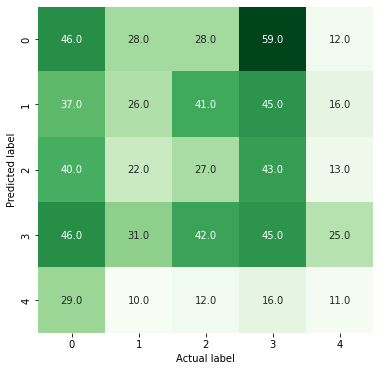

In [204]:
# Visualize Confusion Matrix with heatmap
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.heatmap(confusion_matrix(y_test, y_pred),
                 annot=True,
                 cbar=False,
                 cmap="Greens", fmt = '0.1f')
plt.xlabel("Actual label")
plt.ylabel("Predicted label")
plt.show()

In [205]:
Topicnames_target = ["Bank account services", "Credit card / Prepaid card", "Others", "Theft/Dispute reporting", "Mortgages/loans"]

In [206]:
# Print Classification Report
print(classification_report(y_test, y_pred, target_names = Topicnames_target))

                            precision    recall  f1-score   support

     Bank account services       0.23      0.27      0.25       173
Credit card / Prepaid card       0.22      0.16      0.18       165
                    Others       0.18      0.19      0.18       145
   Theft/Dispute reporting       0.22      0.24      0.23       189
           Mortgages/loans       0.14      0.14      0.14        78

                  accuracy                           0.21       750
                 macro avg       0.20      0.20      0.20       750
              weighted avg       0.21      0.21      0.21       750



Inference

Logistic Regression is the best model with an accuracy of 89% with Precision and Recall as 23% and 27% respectively